# Projeto de Aprendizagem Automática II

## Procura de Exoplanetas no Espaço através da Emissão de Luz de Estrelas

### Importação de Bibliotecas

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model
import keras.backend as K
from keras.layers import *
from keras.optimizers import Adam
import matplotlib            
import matplotlib.pyplot as plt

Using TensorFlow backend.


### Carregamento dos Dados

In [2]:
treino = pd.read_csv("../../../Dados/dados_treino.csv")
teste = pd.read_csv("../../../Dados/dados_teste.csv")

### Preparação para Treino e Teste

O primeiro passo é a preparação dos dados para o tipo de rede que se está a criar. Assim, além da divisão entre atributos e *labels*, a variável de decisão deve ser categorizada. Além disso, tendo em conta o formato de entrada dos dados numa rede convolucional, os registos têm que estar no formato (altura, largura, profundidade). Tendo em conta que apenas se está a lidar com uma *feature*, sendo esta o valor de *flux* ao longo do tempo, ou seja, na visão de uma rede convolucional, esta está a lidar com sinais contínuos (uma dimensão), o formato gerado tem que ser (-1, sistemas, 1). 

In [3]:
Y = treino['LABEL']
X = treino.loc[:, treino.columns != 'LABEL']
X_train = X.values.reshape(-1, X.shape[1], 1)

Yt = teste['LABEL']
Xt = teste.loc[:, teste.columns != 'LABEL']
X_test = Xt.values.reshape(-1, Xt.shape[1], 1)

# One Hot Encoding
y_train = to_categorical(Y.values)
y_train = y_train[:, 1:]

y_test = to_categorical(Yt.values)
y_test = y_test[:, 1:]

### Modelo

No que toca ao modelo, a ideia passou por experimentar a *API* do módulo *Keras* para a modelação deste. Assim, numa fase inicial, o modelo segue o padrão camada convolucional 1D seguido por *Max pooling* e *batch normalization*. No que toca à fase que permite a classificação com o modelo, é aplicada uma camada de achatamento, seguida de um *dropout* e, em seguida, três camadas *Dense*, sendo que a última possui uma função de ativação *softmax* com dois nodos. Cada um destes nodos representa cada uma das possíveis classes do problema.   

In [81]:
# Input: Colunas por registo, features
X = Input(shape=(X_train.shape[1], 1))
y = Conv1D(filters=16, kernel_size=16, activation='relu')(X)
y = MaxPool1D()(y)
y = BatchNormalization()(y)
y = Flatten()(y)
y = Dropout(0.25)(y)
y = Dense(256, activation='relu')(y)
y = Dense(32, activation="relu")(y)
classes = Dense(2, activation="softmax")(y)

É importante realçar a divisão do conjunto de treino em dois conjuntos: treino e validação, sendo o último utilizado como medida de validação do modelo.

In [43]:
train, validation, train_target, validation_target = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

A partir do modelo definido com a *API* mencionada, apenas é necessário indicar que a variável do modelo é a conversão da sequência para um modelo. No que toca ao otimizador do modelo, foi utilizado *Adam*, com *learning rate* de 0.001. Além disso, foi definido um *checkpoint* em que este monitoriza a *accuracy* do conjunto de validação, armazenando os pesos do modelo no ponto em que esta métrica é máxima. 

In [48]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
model = Model(inputs=X, outputs=classes)
adam = Adam(lr=0.001)
chk = ModelCheckpoint('best_model.pkl', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

Observando o sumário do modelo, são visíveis as camadas previamente definidas, bem como o formato dos seus outputs e número de parâmetros.

In [49]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3198, 1)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 3183, 16)          272       
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 1591, 16)          0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 1591, 16)          64        
_________________________________________________________________
flatten_6 (Flatten)          (None, 25456)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 25456)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               6516

Em seguida é apresentada uma visualização gráfica do modelo definido.

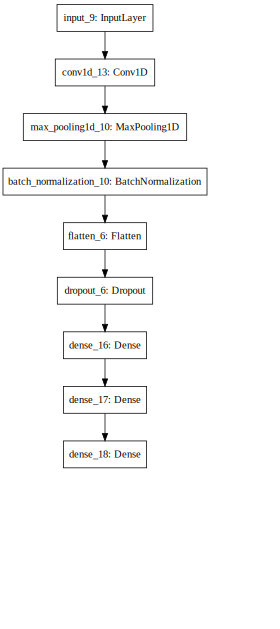

In [50]:
import keras
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.utils.vis_utils.pydot = pyd

#Visualize Model
def visualize_model(model):
  return SVG(model_to_dot(model).create(prog='dot', format='svg'))

visualize_model(model)

### Treino

De modo a permitir a visualização da evolução das métricas ao longo do tempo, foi guardado um histórico dos vários valores das mesmas.

In [51]:
history = model.fit(train, train_target, batch_size=128, epochs=10, shuffle=True, callbacks=[chk], validation_data=(validation, validation_target))

Train on 5252 samples, validate on 1313 samples
Epoch 1/10
5252/5252 [==============================] - 33s 6ms/step - loss: 3.5636 - accuracy: 0.7683 - val_loss: 3.4670 - val_accuracy: 0.7746

Epoch 00001: val_accuracy improved from -inf to 0.77456, saving model to best_model.pkl
Epoch 2/10
5252/5252 [==============================] - 31s 6ms/step - loss: 2.1164 - accuracy: 0.8353 - val_loss: 0.3988 - val_accuracy: 0.9421

Epoch 00002: val_accuracy improved from 0.77456 to 0.94212, saving model to best_model.pkl
Epoch 3/10
5252/5252 [==============================] - 31s 6ms/step - loss: 0.0838 - accuracy: 0.9804 - val_loss: 0.0453 - val_accuracy: 0.9886

Epoch 00003: val_accuracy improved from 0.94212 to 0.98858, saving model to best_model.pkl
Epoch 4/10
5252/5252 [==============================] - 30s 6ms/step - loss: 0.0173 - accuracy: 0.9968 - val_loss: 0.0353 - val_accuracy: 0.9939

Epoch 00004: val_accuracy improved from 0.98858 to 0.99391, saving model to best_model.pkl
Epoch 5

De modo a visualizar a evolução das métricas ao longo do tempo, foi definida uma função que recebe a variável de histórico do treino, o nome da métrica no conjunto de treino e no de validação. Tendo estes valores, a função devolve a representação gráfica da evolução das métricas.

In [10]:
def show_train_history(train_history,train,validation):
    plt.figure(figsize=(12,8))
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

No que toca às métricas de *accuracy*, é visível que são bastante altas, como seria de esperar pelo enorme número de registos de sistemas sem exoplanetas. Come se pode ver ainda, a curva apresenta um comportamento normal, mostrando que aparentemente o modelo aprendeu corretamente as caraterísticas de ambas as classes.

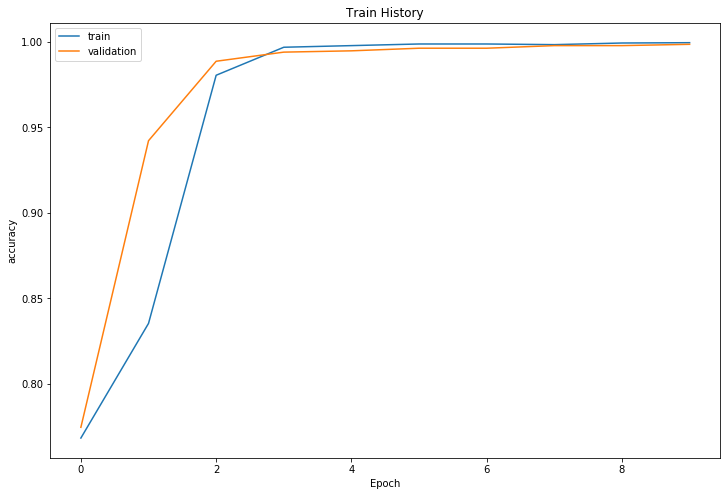

In [56]:
show_train_history(history,'accuracy','val_accuracy')

Já no que toca à curva da *loss*, é notório que o valor desce de forma adequada à medida que o treino é efetuado, não apresentando sinais de *overfitting*.

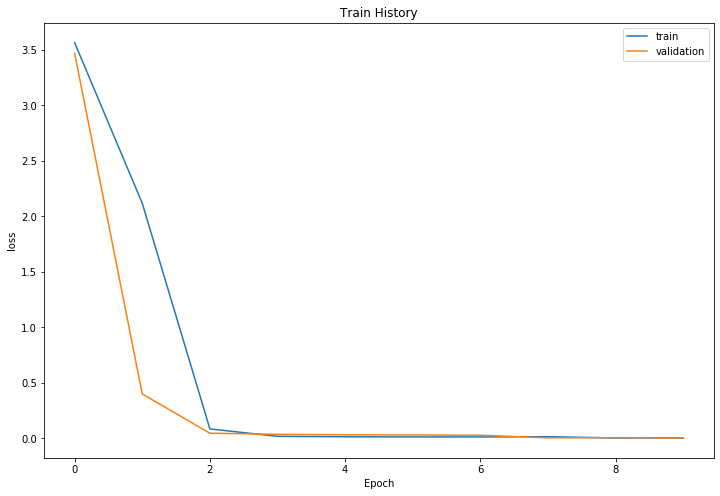

In [57]:
show_train_history(history,'loss','val_loss')

### Teste

Para testar o modelo treinado, é necessário carregar o modelo guardado como melhor modelo durante o treino.

In [58]:
model = load_model('best_model.pkl')

Assim, é necessário aplicar o método de predição do modelo aos dados de teste. Note-se que como foi utilizada a *API* do módulo *Keras*, não é possível utilizar o método *predict_classes* como no caso do modelo com *LSTM*. Assim, foi aplicada o método *predict* *standard*, seguido de uma operação em que se selecionava uma classe consoante o valor probabilístico da mesma. É, também, importante mencionar que os resultados são categorizados para fácil comparação com os valores reais.

In [78]:
from sklearn.metrics import accuracy_score, classification_report
test_preds = model.predict(X_test)
test_preds = test_preds.argmax(axis=-1)
test_preds = to_categorical(test_preds)

Observando as métricas, é possível observar que a métrica de precisão na classe minoritária é 0.67 e o *recall* 0.8. Além disso, a precisão geral do modelo para o conjunto de teste é de 99.47%, tratando-se de um modelo com bastante potencial.

In [79]:
print(classification_report(y_test, test_preds))
accuracy_score(y_test, test_preds)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       565
           1       0.67      0.80      0.73         5

   micro avg       0.99      0.99      0.99       570
   macro avg       0.83      0.90      0.86       570
weighted avg       1.00      0.99      0.99       570
 samples avg       0.99      0.99      0.99       570



0.9947368421052631

Pela análise das matrizes de confusão de ambas as classes, é visível que o modelo classificou corretamente 4 dos 5 sistemas com exoplanetas. É, também, importante mencionar que classificou como possuindo exoplanetas 2 sistemas de forma errada. Apesar destas falhas, este tipo de rede mostra um potencial elevado, pelo que deve ser explorada em mais detalhe.

In [80]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_test, test_preds)

array([[[  4,   1],
        [  2, 563]],

       [[563,   2],
        [  1,   4]]])

### Afinamento do Modelo

Tendo em conta os bons resultados obtidos, testar um modelo que tenha como base o anterior, mas com alguma complexidade extra pode provar-se proveitoso. Assim, a ideia passou por acrescentar outra camada de convolução, com 32 filtros, devido ao aumento da profundidade da rede e à redução da dimensão do *input* através da camada de *Max Pooling*. 

In [4]:
# Input: Colunas por registo, features
X = Input(shape=(X_train.shape[1], 1))
y = Conv1D(filters=16, kernel_size=16, activation='relu')(X)
y = MaxPool1D()(y)
y = BatchNormalization()(y)
y = Conv1D(filters=32, kernel_size=16, activation='relu')(y)
y = MaxPool1D()(y)
y = BatchNormalization()(y)
y = Flatten()(y)
y = Dropout(0.25)(y)
y = Dense(256, activation='relu')(y)
y = Dense(32, activation="relu")(y)
classes = Dense(2, activation="softmax")(y)

Mais, uma vez, foi efetuada a divisão dos dados entre treino e validação, de modo a analisar da melhor forma o modelo.

In [5]:
train, validation, train_target, validation_target = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [6]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
model = Model(inputs=X, outputs=classes)
adam = Adam(lr=0.001)
chk = ModelCheckpoint('best_model.pkl', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

Pela visualização do sumário do modelo, podem ser vistas as adições feitas quando em comparação com o modelo base previamente treinado.

In [7]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3198, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3183, 16)          272       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1591, 16)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1591, 16)          64        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1576, 32)          8224      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 788, 32)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 788, 32)           128 

Mais uma vez, o histórico do treino foi armazenado para permitir uma análise visual das métricas.

In [8]:
history = model.fit(train, train_target, batch_size=128, epochs=10, shuffle=True, callbacks=[chk], validation_data=(validation, validation_target))

Train on 5252 samples, validate on 1313 samples
Epoch 1/10
5252/5252 [==============================] - 67s 13ms/step - loss: 0.5466 - accuracy: 0.9356 - val_loss: 0.5030 - val_accuracy: 0.9444

Epoch 00001: val_accuracy improved from -inf to 0.94440, saving model to best_model.pkl
Epoch 2/10
5252/5252 [==============================] - 64s 12ms/step - loss: 0.0400 - accuracy: 0.9945 - val_loss: 0.0365 - val_accuracy: 0.9939

Epoch 00002: val_accuracy improved from 0.94440 to 0.99391, saving model to best_model.pkl
Epoch 3/10
5252/5252 [==============================] - 63s 12ms/step - loss: 0.0431 - accuracy: 0.9950 - val_loss: 0.0142 - val_accuracy: 0.9970

Epoch 00003: val_accuracy improved from 0.99391 to 0.99695, saving model to best_model.pkl
Epoch 4/10
5252/5252 [==============================] - 62s 12ms/step - loss: 0.0489 - accuracy: 0.9949 - val_loss: 0.0237 - val_accuracy: 0.9970

Epoch 00004: val_accuracy did not improve from 0.99695
Epoch 5/10
5252/5252 [=================

A partir da época 7 parece começar a ocorrer *overfitting*, como se pode observar pela descida da *accuracy* do conjunto de validação. Isto deve-se a uma adaptação elevada do modelo aos dados de treino, não se conseguindo adaptar a novos dados.

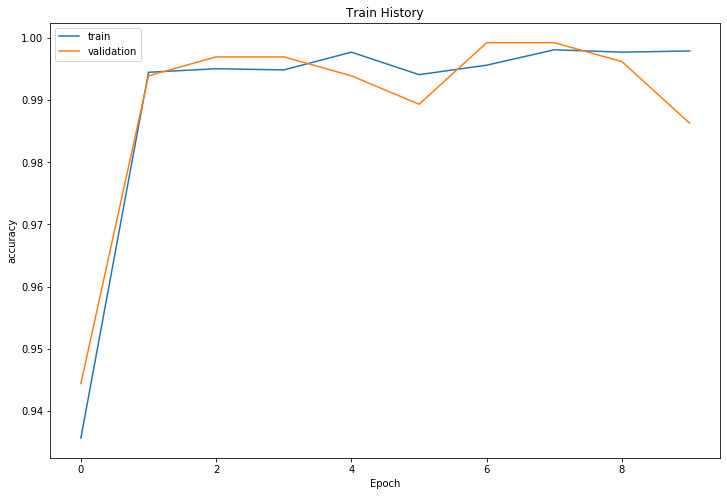

In [11]:
show_train_history(history,'accuracy','val_accuracy')

Tal como na análise da *accuracy*, a análise da *loss* permite constatar a existência de *overftting* a partir da época 7.

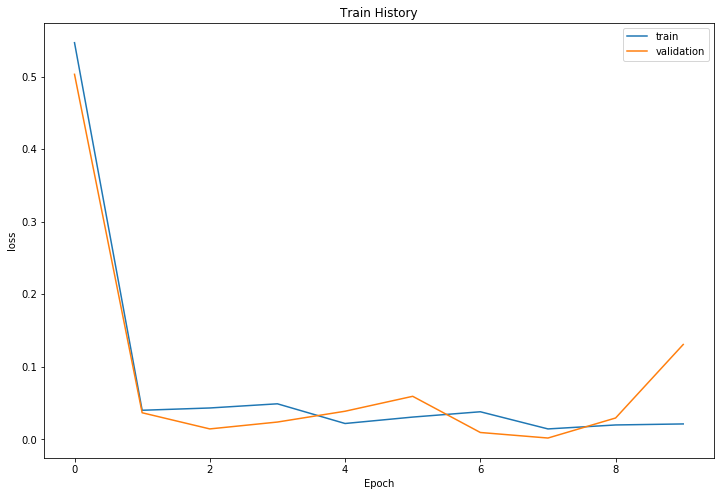

In [12]:
show_train_history(history,'loss','val_loss')

### Teste

De modo a testar o algoritmo, é necessário carregar o melhor modelo, previamente armazenado. 

In [13]:
model = load_model('best_model.pkl')

Em seguida são calculadas as *labels* com base nos dados de teste, de modo a comparar este novo modelo, com o inicial.

In [14]:
from sklearn.metrics import accuracy_score, classification_report
test_preds = model.predict(X_test)
test_preds = test_preds.argmax(axis=-1)
test_preds = to_categorical(test_preds)

Pela análise das métricas, é visível que as métricas associadas à classe minoritária baixaram, permitindo concluir que a *performance* deste novo modelo não é tão boa quanto o inicial.  

In [15]:
print(classification_report(y_test, test_preds))
accuracy_score(y_test, test_preds)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       565
           1       0.60      0.60      0.60         5

   micro avg       0.99      0.99      0.99       570
   macro avg       0.80      0.80      0.80       570
weighted avg       0.99      0.99      0.99       570
 samples avg       0.99      0.99      0.99       570



0.9929824561403509

Visualizando as matrizes de confusão, é notório que em relação ao modelo testado anteriormente, este modelo apresenta piores resultados, devido ao facto de que este classifica de forma errada um sistema com exoplanetas como não possuindo algum.

In [16]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_test, test_preds)

array([[[  3,   2],
        [  2, 563]],

       [[563,   2],
        [  2,   3]]])

Assim, em jeito de conclusão, este tipo de rede mostrou resultados extremamente bons, especialmente no caso do primeiro modelo, em que a complexidade da rede era inferior quando comparada com o segundo modelo. Desta forma, foi possível classificar de forma correta 4 dos 5 sistemas com exoplanetas no conjunto de teste. Apesar disto, 2 sistemas sem exoplanetas foram classificados como tendo, podendo isto dever-se à existência de *outliers* no fluxo de intensidade luminosa. 